# Import Frameworks

In [0]:
%%writefile setup.sh
git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir ./

Writing setup.sh


In [0]:
!sh setup.sh
!pip install transformers

# Import frameworks
import os
import numpy as np
import pandas as pd
import pickle
import torch
import matplotlib.pyplot as plt
import json
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.colab import drive
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from IPython.display import clear_output

torch.cuda.empty_cache()
clear_output()

# Setup Environments

In [0]:
# plt setup
%matplotlib inline

# drive setup
drive.mount('/content/drive')
dataset_url = "/content/drive/My Drive/NCKUDMPH2/task1/dataset/"
program_url = "/content/drive/My Drive/NCKUDMPH2/task1/program/"

# root = os.getcwd()
# dataset_url = os.path.join(root, "dataset/")
# program_url = os.path.join(root, "program/")

# setup gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# setup parameters
num_labels = 62
batch_size = 64
epochs = 5
learning_rate = 5e-5
adam_epsilon = 1e-8

clear_output()

# Setup BERT

In [0]:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=num_labels)

clear_output()

# Load Data and split it into Train/Dev/Test

In [0]:
dataset = pd.read_csv(dataset_url+'task1_trainset.csv', dtype=str)

# Drop unuse columns
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

# for i in range(len(dataset['Abstract'])):
#     dataset['Abstract'][i] = remove_stopwords(dataset['Abstract'][i])

# Data Partition
trainset, validset = train_test_split(dataset, test_size=0.1, random_state=2018)

trainset.to_csv(dataset_url+'trainset.csv',index=False)
validset.to_csv(dataset_url+'validset.csv',index=False)

# Test Data
testset = pd.read_csv(dataset_url+'task1_public_testset.csv')
testset.drop('Title',axis=1,inplace=True)
testset.drop('Categories',axis=1,inplace=True)
testset.drop('Created Date',axis=1, inplace=True)
testset.drop('Authors',axis=1,inplace=True)

# for i in range(len(dataset['Abstract'])):
#     dataset['Abstract'][i] = remove_stopwords(dataset['Abstract'][i])

testset.to_csv(dataset_url+'testset.csv',index=False)

# Parse Dataset

In [0]:
from itertools import combinations
label_dict = {'BACKGROUND': 0, 'OBJECTIVES':1, 'METHODS':2, 'RESULTS':3, 'CONCLUSIONS':4, 'OTHERS':5}
arr = ['BACKGROUND', 'OBJECTIVES', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'OTHERS']
j = 5
for i in range(2, 7):
    combs = list(combinations(arr, i))
    for comb in combs:
        comb = "/".join(list(comb))
        j += 1
        label_dict[comb] = j

In [2]:
label_dict


{'BACKGROUND': 0,
 'BACKGROUND/CONCLUSIONS': 9,
 'BACKGROUND/CONCLUSIONS/OTHERS': 30,
 'BACKGROUND/METHODS': 7,
 'BACKGROUND/METHODS/CONCLUSIONS': 26,
 'BACKGROUND/METHODS/CONCLUSIONS/OTHERS': 49,
 'BACKGROUND/METHODS/OTHERS': 27,
 'BACKGROUND/METHODS/RESULTS': 25,
 'BACKGROUND/METHODS/RESULTS/CONCLUSIONS': 47,
 'BACKGROUND/METHODS/RESULTS/CONCLUSIONS/OTHERS': 60,
 'BACKGROUND/METHODS/RESULTS/OTHERS': 48,
 'BACKGROUND/OBJECTIVES': 6,
 'BACKGROUND/OBJECTIVES/CONCLUSIONS': 23,
 'BACKGROUND/OBJECTIVES/CONCLUSIONS/OTHERS': 46,
 'BACKGROUND/OBJECTIVES/METHODS': 21,
 'BACKGROUND/OBJECTIVES/METHODS/CONCLUSIONS': 42,
 'BACKGROUND/OBJECTIVES/METHODS/CONCLUSIONS/OTHERS': 58,
 'BACKGROUND/OBJECTIVES/METHODS/OTHERS': 43,
 'BACKGROUND/OBJECTIVES/METHODS/RESULTS': 41,
 'BACKGROUND/OBJECTIVES/METHODS/RESULTS/CONCLUSIONS': 56,
 'BACKGROUND/OBJECTIVES/METHODS/RESULTS/CONCLUSIONS/OTHERS': 62,
 'BACKGROUND/OBJECTIVES/METHODS/RESULTS/OTHERS': 57,
 'BACKGROUND/OBJECTIVES/OTHERS': 24,
 'BACKGROUND/OBJECTIVE

In [0]:
def label_to_ids_list(sentence):
    new_sent = "[CLS] " + sentence + " [SEP]"
    ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenizer.tokenize(new_sent)]
    return ids

In [0]:
def generate_masks(input_ids):
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [0]:
# sent_list += [tokenizer.encode(abstract, add_special_tokens=True)
#               for abstract in abstract_parts]

def generate_dataloader(dataset, labeling, sequntial):
    sent_list, label_list = [], []
    for i in dataset.iterrows():
        abstract_parts = i[1]['Abstract'].split('$$$')
        sent_list += [label_to_ids_list(abstract) for abstract in abstract_parts]
        if labeling:
            label_parts = i[1]['Task 1'].split(" ")
            label_list += [label_dict[label] for label in label_parts]
    input_ids = pad_sequences([txt for txt in sent_list],
                              maxlen=64, dtype="long",
                              truncating="post", padding="post")
    attention_masks = generate_masks(input_ids)
    inputs = torch.tensor(input_ids)
    if labeling:
        labels = torch.tensor(label_list)
    masks = torch.tensor(attention_masks)

    dataset = TensorDataset(
        inputs, masks, labels) if labeling else TensorDataset(inputs, masks)
    train_sampler = SequentialSampler(
        dataset) if sequntial else RandomSampler(dataset)
    return DataLoader(dataset, sampler=train_sampler,
                      batch_size=batch_size, num_workers=0)

In [0]:
if os.path.exists(program_url+'train_dataloader_{}'.format(batch_size)):
    with open(program_url+'train_dataloader_{}'.format(batch_size), 'rb') as f:
        train_dataloader = pickle.load(f)
    with open(program_url+'valid_dataloader_{}'.format(batch_size), 'rb') as f:
        valid_dataloader = pickle.load(f)
    with open(program_url+'test_dataloader_{}'.format(batch_size), 'rb') as f:
        test_dataloader = pickle.load(f)
else:
    train_dataloader = generate_dataloader(trainset, True, False)
    with open(program_url+'train_dataloader_{}'.format(batch_size), 'wb') as f:
        pickle.dump(train_dataloader, f)
    valid_dataloader = generate_dataloader(validset, True, True)
    with open(program_url+'valid_dataloader_{}'.format(batch_size), 'wb') as f:
        pickle.dump(valid_dataloader, f)
    test_dataloader = generate_dataloader(testset, False, True)
    with open(program_url+'test_dataloader_{}'.format(batch_size), 'wb') as f:
        pickle.dump(test_dataloader, f)

# Start Training

In [0]:
class F1():
    def __init__(self):
        self.threshold = 0.5
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.uint8)
                                     * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / \
            (self.n_precision + 1e-20)  # prevent divided by zero
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)

In [0]:
def run_epoch(epoch, isTraining):
    if isTraining:
        model.train()
    else:
        model.eval()

    f1_score = F1()
    loss = 0
    dataloader = train_dataloader if isTraining else valid_dataloader
    desc = "Train" if isTraining else "Valid"

    trange = tqdm(enumerate(dataloader), total=len(
        dataloader), desc=desc)

    for i, batch in trange:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.long()

        # Extract tensor from tuple
        if isTraining:
            optimizer.zero_grad()
            prediction = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            batch_loss = prediction[0]
            o_labels = prediction[1].float().argmax(1)
        else:
            with torch.no_grad(): 
                prediction = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                batch_loss = prediction[0]
                o_labels = prediction[1].float().argmax(1)

        if isTraining:
            with amp.scale_loss(batch_loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            
        loss += batch_loss.item()
        f1_score.update(o_labels, b_labels)
        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
        history['train' if isTraining else 'valid'].append(
            {'f1': f1_score.get_score(), 'loss': loss / len(trange)})
        
        # flush memory
        del o_labels, b_input_ids, b_labels, b_input_mask, batch_loss

In [0]:
def save(epoch):
    if not os.path.exists(program_url+'model'):
        os.makedirs(program_url+'model')
    torch.save(model.state_dict(), program_url+'model/model.pkl.'+str(epoch))
    with open(program_url+'model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

In [0]:
from apex import amp

torch.distributed

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

# BCELoss can't handle negative values
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

model.to(device)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1")

history = {'train': [], 'valid': []}
train_loss_set = []

for epoch in range(epochs):
    run_epoch(epoch, True)
    run_epoch(epoch, False)
    save(epoch)

Train:   0%|          | 0/658 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Train:   6%|▌         | 40/658 [00:17<04:32,  2.27it/s, f1=1.61207, loss=0.815]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


Train:  31%|███       | 204/658 [01:28<03:08,  2.41it/s, f1=1.61089, loss=0.634]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


Valid: 100%|██████████| 75/75 [00:09<00:00,  7.66it/s, f1=1.50463, loss=1.78]


# Ploting the Results

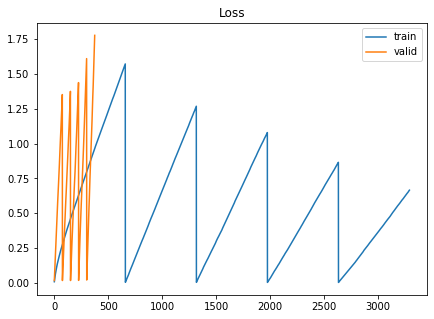

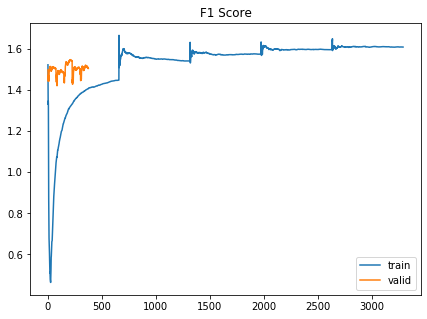

Best F1 score  [1.5476473905143786, 211]


In [0]:
with open(program_url+'model/history.json', 'r') as f:
    history = json.loads(f.read())

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7, 5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx]
                             for idx, l in enumerate(history['valid'])]))

# Prediction

In [0]:
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['BACKGROUND'] = list(prediction[:,0]) + [0]*redundant
        submit['OBJECTIVES'] = list(prediction[:,1]) + [0]*redundant
        submit['METHODS'] = list(prediction[:,2]) + [0]*redundant
        submit['RESULTS'] = list(prediction[:,3]) + [0]*redundant
        submit['CONCLUSIONS'] = list(prediction[:,4]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,5]) + [0]*redundant
    else:
        submit['BACKGROUND'] = [0]*redundant + list(prediction[:,0])
        submit['OBJECTIVES'] = [0]*redundant + list(prediction[:,1])
        submit['METHODS'] = [0]*redundant + list(prediction[:,2])
        submit['RESULTS'] = [0]*redundant + list(prediction[:,3])
        submit['CONCLUSIONS'] = [0]*redundant + list(prediction[:,4])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,5])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [0]:
# model.train(False)
# trange = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc='Test')
# prediction = []  # prediction will be a (131166, 6) list

# for i, batch in trange:
#     batch = tuple(t.to(device) for t in batch)
#     b_input_ids, b_input_mask = batch
#     b_input_ids = b_input_ids.long()
#     with torch.no_grad():
#         o_labels = model(b_input_ids, b_input_mask)[0]
#     o_labels = o_labels > 0.5
#     batch_result = np.where(o_labels.cpu().numpy(), 1, 0)  # convert True/False into 1/0
#     prediction.extend(batch_result)
# prediction = np.array(prediction)

# Submit Prediction Results

In [0]:
# SubmitGenerator(prediction,
#                 dataset_url+'task1_sample_submission.csv', 
#                 True, 
#                 dataset_url+'task1_submission.csv')